In this study, my objective is to leverage a supervised machine learning algorithm to predict the future categorization of customers. This categorization is based on the eight distinct customer segments identified through our preceding cluster analysis.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb
from sklearn import metrics

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, make_scorer,
    accuracy_score, roc_auc_score, recall_score, balanced_accuracy_score,
    precision_score, f1_score, RocCurveDisplay)
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Data
customer = pd.read_csv('../data/customer_seg.csv')

customer.rename(columns = {'cluster_sec': 'class'}, inplace = True)

customer.head()

,recency,frequency_item,frequency_order,monetary,class
0,325,1,1,0.00,1
1,2,103,7,4310.00,0
2,75,22,4,1797.24,3
3,18,73,1,1757.55,3
4,310,17,1,334.40,1


In [3]:
# Baseline
customer['class'].value_counts(normalize = True)

3    0.490436
1    0.233925
0    0.208343
6    0.047246
7    0.016363
5    0.002305
4    0.000691
2    0.000691
Name: class, dtype: float64

In [4]:
# Split Data
X = customer.drop(columns = ['class'])
y = customer['class']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [6]:
# Create evaluation function
def evaluation(X_test, y_test, preds, model=None):
    if model:
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    # Use weighted to handle unbalanced data
    recall = recall_score(y_test, preds, average = 'weighted')
    prec = precision_score(y_test, preds, average = 'weighted')
    f1 = f1_score(y_test, preds, average = 'weighted')

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

scores = []

### Model 1. Logistic Regression

In [7]:
pipe_lgr = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state = 42, class_weight='balanced'))
])

In [8]:
params_lgr = {
    'model__penalty': ['l2'],
    'model__max_iter': [1000, 2000],
    'model__C': [1, 10, 100, 1000]
}

In [9]:
gs_lgr = GridSearchCV(pipe_lgr, param_grid = params_lgr, cv = 5, scoring = 'balanced_accuracy')

In [10]:
gs_lgr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             param_grid={'model__C': [1, 10, 100, 1000],
                         'model__max_iter': [1000, 2000],
                         'model__penalty': ['l2']},
             scoring='balanced_accuracy')

In [11]:
preds_lgr = gs_lgr.predict(X_test)

balanced_accuracy: 0.9303388448998603
recall: 0.9797235023041475
precision: 0.9807285521067672
f1 score: 0.9797695420384879


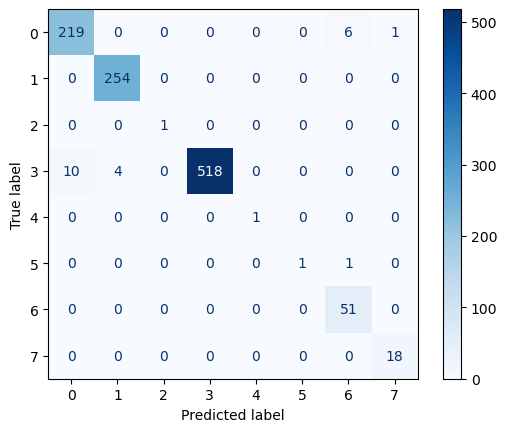

In [12]:
scores.append(evaluation(X_test, y_test, preds_lgr, gs_lgr))

### Model 2. Multinomial Naive Bayes

balanced_accuracy: 0.54656766864045
recall: 0.5953917050691244
precision: 0.6726992455982663
f1 score: 0.6064650935979761


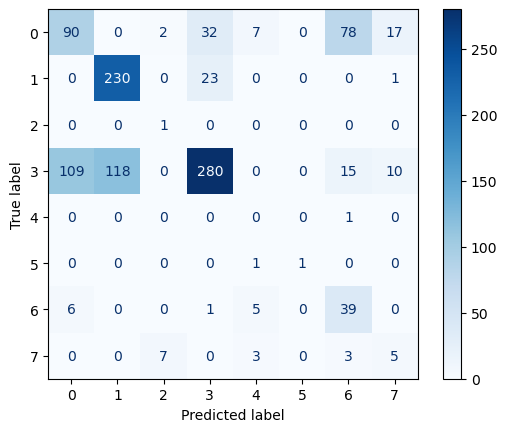

In [13]:
pipe_mnb = Pipeline(steps = [
    ('model', MultinomialNB())
])

params_mnb = {
    'model__alpha': [0.1, 0.5, 1.0, 2.0, 10.0]
}

gs_mnb = GridSearchCV(pipe_mnb, param_grid = params_mnb, cv = 5, scoring = 'balanced_accuracy')

gs_mnb.fit(X_train, y_train)

preds_mnb = gs_mnb.predict(X_test)

scores.append(evaluation(X_test, y_test, preds_mnb, gs_mnb))

### Model 3. K-Nearest Neighbors

In [14]:
pipe_knn = Pipeline(steps = [
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier())
])

balanced_accuracy: 0.9898125659903487
recall: 0.9797235023041475
precision: 0.9798628604519551
f1 score: 0.9797422186173985


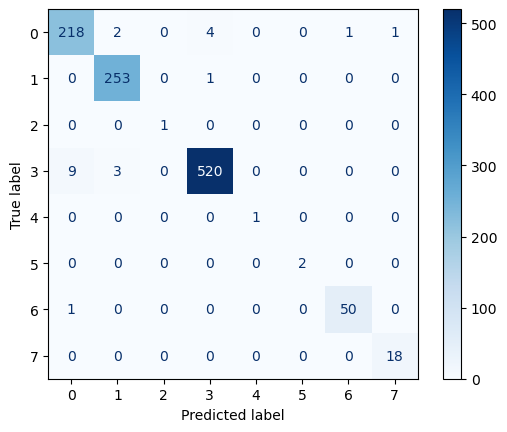

In [15]:
params_knn = {
    'model__n_neighbors': [*range(1, 50, 1)],
    'model__metric': ['euclidean', 'manhattan'],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2, 3]
}

gs_knn = GridSearchCV(pipe_knn, param_grid = params_knn, cv = 5, scoring = 'balanced_accuracy')

gs_knn.fit(X_train, y_train)

preds_knn = gs_knn.predict(X_test)

scores.append(evaluation(X_test, y_test, preds_knn, gs_knn))

### Model 4. Decision Tree

In [16]:
pipe_dt = Pipeline(steps = [
    ('model', DecisionTreeClassifier(random_state=42))
])

balanced_accuracy: 0.9898125659903487
recall: 0.9797235023041475
precision: 0.9798628604519551
f1 score: 0.9797422186173985


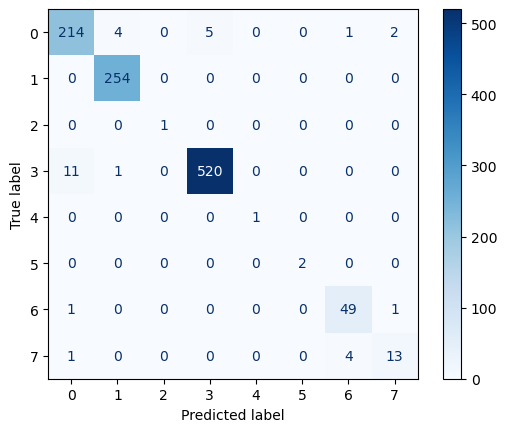

In [17]:
params_dt = {
    'model__criterion': ['gini', 'entropy']
}

gs_dt = GridSearchCV(pipe_dt, param_grid = params_dt, cv = 5, scoring = 'balanced_accuracy')

gs_dt.fit(X_train, y_train)

preds_dt = gs_knn.predict(X_test)

scores.append(evaluation(X_test, y_test, preds_dt, gs_dt))

### Model 5. Random Forest

In [18]:
pipe_rf = Pipeline(steps = [
    ('model', RandomForestClassifier(random_state=42))
])

In [19]:
params_rf = {
    'model__criterion': ['gini', 'entropy']
}

balanced_accuracy: 0.9898125659903487
recall: 0.9797235023041475
precision: 0.9798628604519551
f1 score: 0.9797422186173985


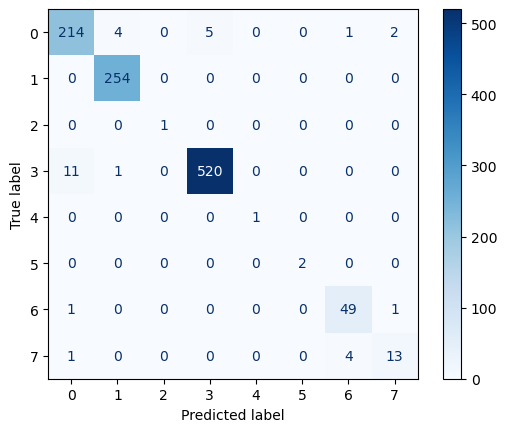

In [20]:
params_rf = {
    'model__criterion': ['gini', 'entropy']
}

gs_rf = GridSearchCV(pipe_rf, param_grid = params_rf, cv = 5, scoring = 'balanced_accuracy')

gs_rf.fit(X_train, y_train)

preds_rf = gs_knn.predict(X_test)

scores.append(evaluation(X_test, y_test, preds_rf, gs_dt))

### Model 6. XGBoost

In [21]:
pipe_xgb = Pipeline(steps = [
    ('model', xgb.XGBClassifier(random_state=42))
])

balanced_accuracy: 0.9898125659903487
recall: 0.9797235023041475
precision: 0.9798628604519551
f1 score: 0.9797422186173985


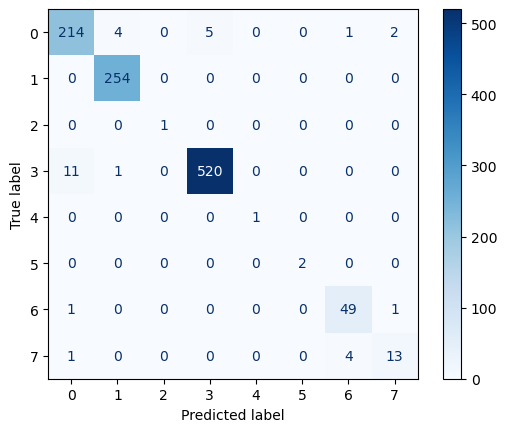

In [22]:
params_xgb = {
    'model__use_label_encoder': [False],
    'model__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.3]
}

gs_xgb = GridSearchCV(pipe_xgb, param_grid = params_xgb, cv = 5, scoring = 'balanced_accuracy')

gs_xgb.fit(X_train, y_train)

preds_xgb = gs_knn.predict(X_test)

scores.append(evaluation(X_test, y_test, preds_xgb, gs_dt))

### Model 7. Weighted Averaging

In [23]:
preds = pd.DataFrame({'Logistic Regression': preds_lgr, 
                      'Multinomial Naive Bayes': preds_mnb, 
                      'K-Nearest Neighbor': preds_knn, 
                      'Decision Tree': preds_dt, 
                      'Random Forest': preds_rf, 
                      'XGBoost': preds_xgb}, index = y_test.index)
preds

,Logistic Regression,Multinomial Naive Bayes,K-Nearest Neighbor,Decision Tree,Random Forest,XGBoost
2387,3,3,3,3,3,3
410,1,3,1,1,1,1
1570,3,3,3,3,3,3
3743,3,0,3,3,3,3
1736,0,7,0,0,0,0
...,...,...,...,...,...,...
525,3,3,3,3,3,3
1468,3,3,3,3,3,3
3918,1,3,1,1,1,1
2348,3,1,3,3,3,3


In [24]:
preds_weight = preds.apply(lambda x: mode(x)[0][0], axis = 1)

preds_weight

2387    3
410     1
1570    3
3743    3
1736    0
       ..
525     3
1468    3
3918    1
2348    3
2729    0
Length: 1085, dtype: int64

In [25]:
scores.append(evaluation(X_test, y_test, preds_weight))

balanced_accuracy: 0.9898125659903487
recall: 0.9797235023041475
precision: 0.9798628604519551
f1 score: 0.9797422186173985


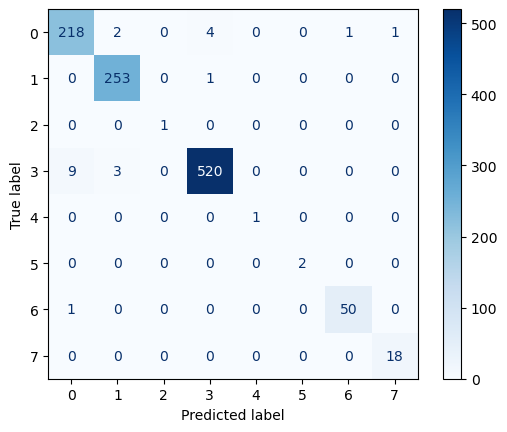

In [26]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds_weight)).plot(cmap='Blues');

### Model 8. Stacking

In [27]:
stacking = StackingClassifier(
    estimators = [
        ('mnb', gs_mnb.best_estimator_),
        ('knn', gs_knn.best_estimator_),
        ('dt', gs_dt.best_estimator_),
        ('rf', gs_rf.best_estimator_),
        ('xgb', gs_xgb.best_estimator_)
    ],
    final_estimator = LogisticRegression(random_state=42)
)

In [28]:
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('mnb',
                                Pipeline(steps=[('model',
                                                 MultinomialNB(alpha=0.1))])),
                               ('knn',
                                Pipeline(steps=[('scale', StandardScaler()),
                                                ('model',
                                                 KNeighborsClassifier(metric='manhattan',
                                                                      n_neighbors=1,
                                                                      p=1))])),
                               ('dt',
                                Pipeline(steps=[('model',
                                                 DecisionTreeClassifier(criterion='entropy',
                                                                        random_state=42))])),
                               ('rf',
                                Pipeline(steps=[('model',
                

In [29]:
preds_stack = stacking.predict(X_test)

balanced_accuracy: 0.8593000971542164
recall: 0.9824884792626728
precision: 0.9816278544389143
f1 score: 0.9820292395965906


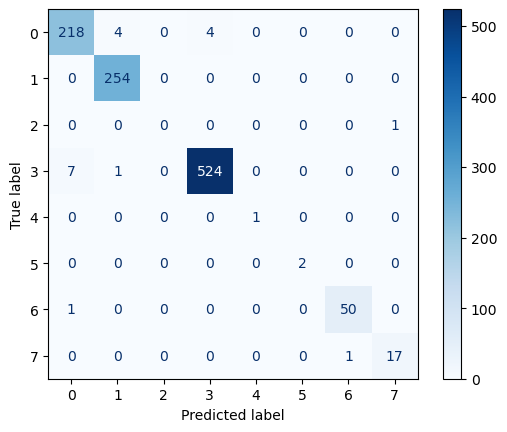

In [30]:
scores.append(evaluation(X_test, y_test, preds_stack, stacking))

### Compare results

In [31]:
evaluations = pd.DataFrame(scores, index = ['Logistic Regression', 
                                            'Multinomial Naive Bayes', 
                                            'K-Nearest Neighbor', 
                                            'Decision Tree', 
                                            'Random Forest', 
                                            'XGBoost', 
                                            'Average Weighting', 
                                            'Stacking'])
evaluations

,balanced_accuracy,recall,precision,f1_score
Logistic Regression,0.930339,0.979724,0.980729,0.979770
Multinomial Naive Bayes,0.546568,0.595392,0.672699,0.606465
K-Nearest Neighbor,0.989813,0.979724,0.979863,0.979742
Decision Tree,0.989813,0.979724,0.979863,0.979742
Random Forest,0.989813,0.979724,0.979863,0.979742
XGBoost,0.989813,0.979724,0.979863,0.979742
Average Weighting,0.989813,0.979724,0.979863,0.979742
Stacking,0.859300,0.982488,0.981628,0.982029


The results from various machine learning models for customer classification indicate a high level of performance across the board, with certain models delivering superior results. Given that this is a multi-classification problem with class imbalances, the balanced accuracy metric was prioritized in evaluating model performance.

- Logistic Regression: This model achieved solid results, with a balanced accuracy of 93.03%, which is impressive given the unbalanced nature of the classification problem. The recall was 97.97%, precision 98.07%, and F1 score 97.98%, all reflecting the model's overall good performance.

- Multinomial Naive Bayes: The balanced accuracy for this model was relatively moderate at 54.66%, suggesting that it struggled to handle the class imbalance in the data. Other metrics also showed moderate results with a recall of 59.54%, precision of 67.27%, and an F1 score of 60.65%.

- K-Nearest Neighbor, Decision Tree, Random Forest, XGBoost, and Average Weighting: These models all demonstrated outstanding performance with a balanced accuracy of 98.98%, indicating their superior ability to correctly classify customers into their respective clusters even in the presence of class imbalance. All these models achieved a recall of 97.97%, precision of 97.99%, and an F1 score of 97.97%.

- Stacking: The stacked model achieved a balanced accuracy of 85.93%, which is lower compared to the K-Nearest Neighbor, Decision Tree, Random Forest, XGBoost, and Average Weighting models. This suggests that while stacking multiple models can improve performance, it might not always provide the best solution when dealing with imbalanced data. Despite its lower balanced accuracy, the model's recall was 98.25%, precision 98.16%, and the F1 score was 98.20%, reflecting overall good performance.

In conclusion, while all models showed high predictive performance, the K-Nearest Neighbor, Decision Tree, Random Forest, XGBoost, and Average Weighting models delivered the highest balanced accuracy. These models, thus, appear to be particularly well-suited for handling class imbalances and represent strong choices for this task. Meanwhile, the stacking model's balanced accuracy, though good, was not superior to these models.